# ６章　ゲート付きRNN

In [1]:
#必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt

## RNNの問題点

時系列データを扱う上で基礎となる「シンプルなRNN」には問題点があります。  
  
それは長期の依存関係を学習することがとても苦手であるというものです。  
  
この問題点の根本にあるのが勾配爆発・勾配消失です。  
  
一つ例を見てみましょう

今回ゴールにしているのはRNNを使った言語モデルの実装でした。  
  
なので今回は言語モデルで扱うタスクを例に説明していきます。  
  

  
この問題では「？」に入る単語をRNNLMに推測してもらいます。  
  
これを学習する際のRNNLMの逆伝播を見てみましょう。  
  

  
このように逆伝播する際、RNNレイヤをこのように何度も通ります。  
  
この逆伝播の計算は「tanh」「Matmul」「+」の勾配計算が何度も行われることを意味します。
  
それではそれぞれの計算について見ていきましょう。

### +の勾配計算
「+」の逆伝播は値をそのまま下流に流すだけなので影響はありません

### tanhの勾配計算
5章で扱ったようにtanhの微分は以下のようになります。
$$
f(x) = \text{tanh}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

$$
f'(x) = 1 - {f(x)}^{2}
$$

これをグラフにプロットすると下図のようになります。  

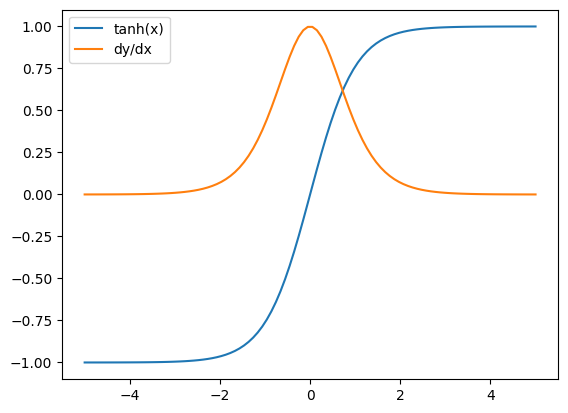

In [3]:
#tanh(x)とその微分のプロット(xの範囲は-5から5)
x = np.linspace(-5, 5, 100)
y = np.tanh(x)
dy = 1 - y**2

plt.plot(x, y, label="tanh(x)")
plt.plot(x, dy, label="dy/dx")
plt.legend()
plt.show()

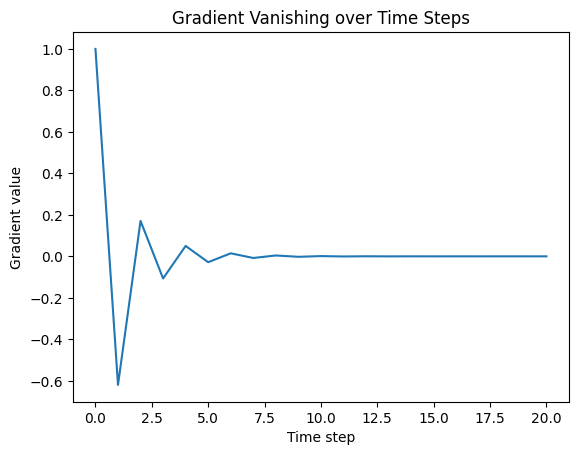

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# シンプルなRNNセル
def rnn_cell_forward(xt, ht_prev, Wxh, Whh, bh):
    ht = np.tanh(np.dot(Wxh, xt) + np.dot(Whh, ht_prev) + bh)
    return ht

# 逆伝播のための勾配の計算
def rnn_cell_backward(dht, ht, Wxh, Whh, xt, ht_prev):
    dtanh = 1 - ht ** 2
    dht_prev = dht * dtanh * Whh
    dWxh = dht * dtanh * xt.T
    dWhh = dht * dtanh * ht_prev.T
    dbh = dht * dtanh
    return dht_prev, dWxh, dWhh, dbh

# パラメータの初期化
#np.random.seed(0)
input_size = 1
hidden_size = 1
xt = np.random.randn(input_size, 1)
ht_prev = np.random.randn(hidden_size, 1)
Wxh = np.random.randn(hidden_size, input_size)
Whh = np.random.randn(hidden_size, hidden_size)
bh = np.random.randn(hidden_size, 1)

# 初期勾配
dht = np.ones((hidden_size, 1))

# 勾配の変化を記録するリスト
gradients = [dht[0, 0]]

# 時系列長
T = 20

# 時系列にわたる逆伝播のシミュレーション
for t in range(T):
    ht = rnn_cell_forward(xt, ht_prev, Wxh, Whh, bh)
    dht, _, _, _ = rnn_cell_backward(dht, ht, Wxh, Whh, xt, ht_prev)
    gradients.append(dht[0, 0])
    ht_prev = ht

# 勾配の変化をプロット
plt.plot(gradients)
plt.xlabel('Time step')
plt.ylabel('Gradient value')
plt.title('Gradient Vanishing over Time Steps')
plt.show()


このようにTime stepを経るたびに勾配が急激に減少しているのがわかります

### MatMulの勾配計算
MatMulレイヤの勾配計算は反対側の行列の転置の積で計算できます。  
  
時間方向の逆伝播では流れてきた勾配にhに対する重み(W_h)の転置をかけていきます。  
  


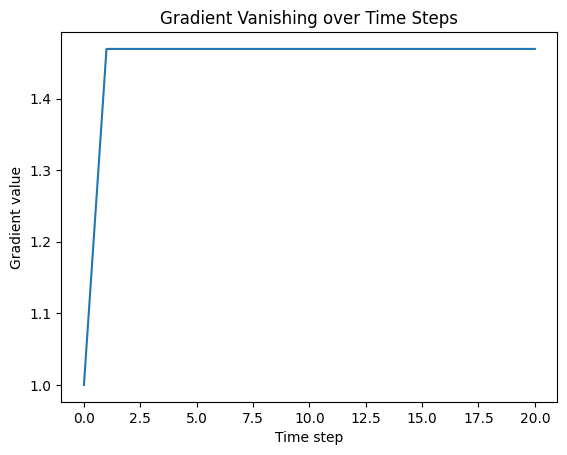

In [91]:
#MatMulレイヤのみの勾配計算による勾配消失のシミュレーション

# シンプルなMatMulレイヤ
def matmul_forward(x, W):
    return np.dot(W, x)

def matmul_backward(dout, x, W):
    dW = np.dot(dout, x.T)
    dx = np.dot(W.T, dout)
    return dx, dW

# パラメータの初期化
#np.random.seed(0)
input_size = 1
output_size = 1
x = np.random.randn(input_size, 1)
W = np.random.randn(output_size, input_size)

# 初期勾配
dout = np.ones((output_size, 1))

# 勾配の変化を記録するリスト
gradients = [dout[0, 0]]

# 時系列長
T = 20

# 時系列にわたる逆伝播のシミュレーション
for t in range(T):
    y = matmul_forward(x, W)
    dx, dW = matmul_backward(dout, x, W)
    gradients.append(dx[0, 0])
    x = y

# 勾配の変化をプロット
plt.plot(gradients)
plt.xlabel('Time step')
plt.ylabel('Gradient value')
plt.title('Gradient Vanishing over Time Steps')
plt.show()

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


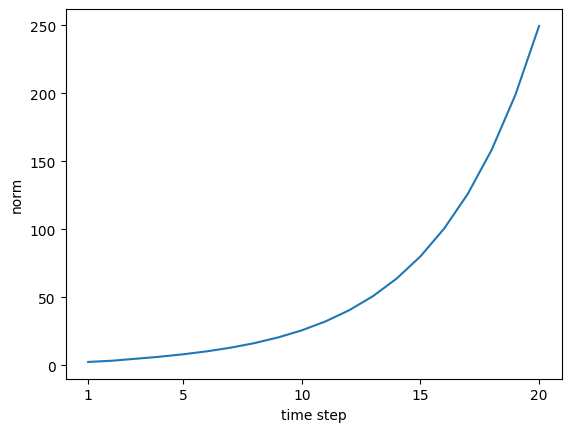

In [92]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


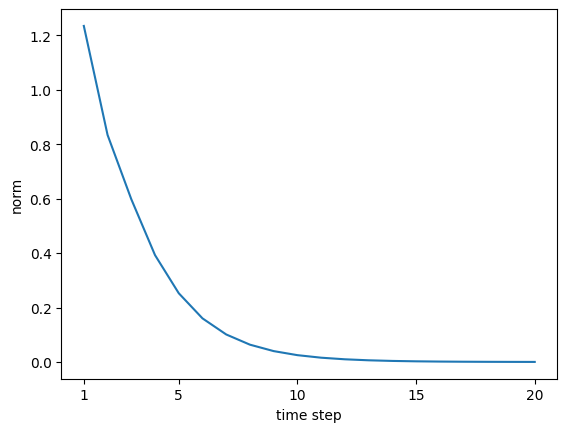

In [93]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

具体的には重み行列の固有値の値によって勾配爆発か勾配消失か変わります。

### 勾配爆発への対策
勾配クリッピング
$$
\text{if} \quad ||\hat{g}|| \geq \text{threshold} :
$$

$$
\hat{g} = \frac{\text{threshold}}{||\hat{g}||} \hat{g}
$$
勾配のL2ノルムがある閾値thresholdを超えた場合、上記のように勾配を修正します。  
  
とても単純な手法なので実装は簡単にできます。

In [5]:
#勾配クリッピングの実装
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [3.56016486 9.53677018 4.76950922 2.78238442 5.03005195 6.43357925
 1.11245673 7.58061658 8.51945771]
after: [0.66906249 1.79224711 0.89633481 0.52289406 0.94529866 1.20906382
 0.20906421 1.42462678 1.60106338]


### 勾配消失への対策
勾配消失問題はさきほどのクリッピングのように簡単には行きません。  
  
これを解決するにはRNNレイヤのアーキテクチャ根本から変える必要があります。  
  
ここから本格的に**LSTM**の話をしていきます

## LSTM(Long short term memory)
LSTMとは長期の依存関係の学習を可能にしたRNNの進化系で、モデルは生物のニューロンの仕組みと言われています。  
  
LSTMには今までのRNNと根本的に違う点が２つあります。  
  
１つ目は**記憶セル**というLSTM内部でのみ情報を伝達する機構があることです。  
  
これは出力へ情報を渡す隠れ状態hとは異なり、外部への出力はしません。  
  
２つ目は**ゲート機構**です。  
  
ゲートは「開く/閉じる」の二択ではなく、どれくらい情報を通すかというのを調整することができます。  
  
今回はシグモイド関数を使ってゲートを作成していきます。  
  
上の２つの点に注意しながらLSTMを構築していきましょう。

![alt text](../pictures/pict6-7.png)

### outputゲート
名前の通り出力に対して作用するゲートで、記憶セルCtにtanhを作用させた後に通します。  
  
式は以下の通り。  

$$
\mathbf{o} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(o)} + \mathbf{b}^{(o)})
$$
  
![alt text](../pictures/pict6-9.png)
  
このゲートの値はそれぞれの要素の比率を表しているためここでの計算は**アダマール積**(要素ごとの積)になります。

### forgetゲート
このゲートは前の時系列から流れてきた記憶セルに直接通すゲートになります。  
  
このゲートは「忘れる」というよりも「情報に優先度を作る」イメージのほうがわかりやすいかもしれません。  
  
式は以下の通り。

$$
\mathbf{f} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(f)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(f)} + \mathbf{b}^{(f)})
$$

![alt text](../pictures/pict6-10.png)

### 新しい記憶セル(getセル)
このセルは新しく覚えるべき情報を記憶セルに追加するためのもです。  
  
注意してほしいのはこれは「ゲート」ではないということです。(後ほどこのセルもゲートに通します)  
  
ゲートはいわばフィルターのようなもので情報そのものではありません。  
  
今回はtanhを使って情報を追加していきます  
  
式は以下の通り。

$$
\mathbf{g} = \tanh (\mathbf{x}_t \mathbf{W}_x^{(g)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(g)} + \mathbf{b}^{(g)})
$$

![alt text](../pictures/pict6-11.png)

### inputゲート
このゲートはgetセルに作用するゲートで、追加する情報の重み付けと捉えることができます。  
  
式は以下の通り。

$$
\mathbf{i} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(i)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(i)} + \mathbf{b}^{(i)})
$$
![alt text](../pictures/pict6-12.png)

LSTMは勾配消失を防ぐために実装したので、実際に勾配消失が起きないか見てみましょう。

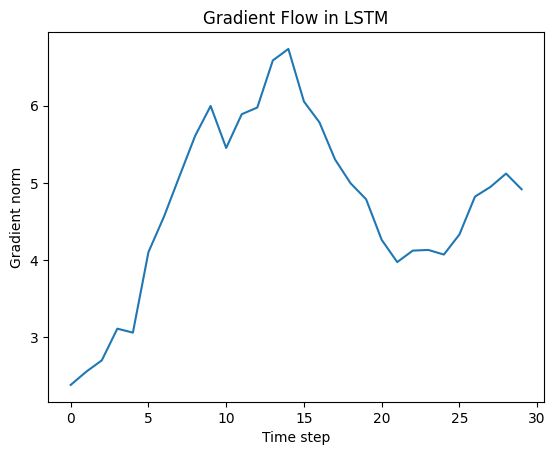

In [9]:
#LSTMの記憶セルの勾配計算のシミュレーション
import numpy as np
import matplotlib.pyplot as plt

# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# シグモイドの微分
def dsigmoid(y):
    return y * (1 - y)

# tanh関数
def tanh(x):
    return np.tanh(x)

# tanhの微分
def dtanh(y):
    return 1 - y ** 2

# LSTMセルのフォワードパス
def lstm_cell_forward(xt, h_prev, C_prev, params):
    Wf, bf, Wi, bi, Wc, bc, Wo, bo = params
    
    concat = np.concatenate((h_prev, xt), axis=0)
    
    ft = sigmoid(np.dot(Wf, concat) + bf)
    it = sigmoid(np.dot(Wi, concat) + bi)
    C_tilde = tanh(np.dot(Wc, concat) + bc)
    C_t = ft * C_prev + it * C_tilde
    ot = sigmoid(np.dot(Wo, concat) + bo)
    h_t = ot * tanh(C_t)
    
    return h_t, C_t, ft, it, C_tilde, ot

# LSTMセルのバックプロパゲーション
def lstm_cell_backward(dh_next, dC_next, C_t, C_prev, ft, it, C_tilde, ot, h_t, params):
    Wf, bf, Wi, bi, Wc, bc, Wo, bo = params
    
    dot = dh_next * tanh(C_t) * dsigmoid(ot)
    dC_t = dh_next * ot * dtanh(tanh(C_t)) + dC_next
    dC_tilde = dC_t * it * dtanh(C_tilde)
    dit = dC_t * C_tilde * dsigmoid(it)
    dft = dC_t * C_prev * dsigmoid(ft)
    
    dconcat = np.dot(Wf.T, dft) + np.dot(Wi.T, dit) + np.dot(Wc.T, dC_tilde) + np.dot(Wo.T, dot)
    dh_prev = dconcat[:h_prev.shape[0], :]
    dxt = dconcat[h_prev.shape[0]:, :]
    
    dWf = np.dot(dft, np.concatenate((h_prev, xt), axis=0).T)
    dbf = dft
    dWi = np.dot(dit, np.concatenate((h_prev, xt), axis=0).T)
    dbi = dit
    dWc = np.dot(dC_tilde, np.concatenate((h_prev, xt), axis=0).T)
    dbc = dC_tilde
    dWo = np.dot(dot, np.concatenate((h_prev, xt), axis=0).T)
    dbo = dot
    
    grads = dWf, dbf, dWi, dbi, dWc, dbc, dWo, dbo
    
    return dh_prev, dC_t, grads

# パラメータの初期化
#np.random.seed(1)
hidden_size = 4
input_size = 2

Wf = np.random.randn(hidden_size, hidden_size + input_size)
bf = np.random.randn(hidden_size, 1)
Wi = np.random.randn(hidden_size, hidden_size + input_size)
bi = np.random.randn(hidden_size, 1)
Wc = np.random.randn(hidden_size, hidden_size + input_size)
bc = np.random.randn(hidden_size, 1)
Wo = np.random.randn(hidden_size, hidden_size + input_size)
bo = np.random.randn(hidden_size, 1)

params = (Wf, bf, Wi, bi, Wc, bc, Wo, bo)

# 初期状態
xt = np.random.randn(input_size, 1)
h_prev = np.random.randn(hidden_size, 1)
C_prev = np.random.randn(hidden_size, 1)

# フォワードパスとバックプロパゲーションのシミュレーション
T = 30
gradients = []
dC_t = np.ones_like(C_prev)

for t in range(T):
    h_t, C_t, ft, it, C_tilde, ot = lstm_cell_forward(xt, h_prev, C_prev, params)
    dh_next = np.random.randn(hidden_size, 1)
    dC_next = np.random.randn(hidden_size, 1)
    
    dh_prev, dC_t, grads = lstm_cell_backward(dh_next, dC_t, C_t, C_prev, ft, it, C_tilde, ot, h_t, params)
    
    gradients.append(np.linalg.norm(dC_t))
    
    h_prev, C_prev = h_t, C_t

# 勾配の変化をプロット
plt.plot(gradients)
plt.xlabel('Time step')
plt.ylabel('Gradient norm')
plt.title('Gradient Flow in LSTM')
plt.show()


上の結果から時間方向の勾配が0に収束することはなくなり、しっかり情報を伝えられていることがわかります。  

### LSTMの実装
それではLSTMの実装をしていきましょう。  
  
今回もRNNのときと同様にTimeレイヤを作る前に1ステップ分のLSTMレイヤ実装します。  
  
LSTMレイヤでの計算は以下のようになります

$$
\mathbf{f} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(f)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(f)} + \mathbf{b}^{(f)})
$$

$$
\mathbf{g} = \tanh (\mathbf{x}_t \mathbf{W}_x^{(g)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(g)} + \mathbf{b}^{(g)})
$$

$$
\mathbf{i} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(i)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(i)} + \mathbf{b}^{(i)})
$$

$$
\mathbf{o} = \sigma (\mathbf{x}_t \mathbf{W}_x^{(o)} + \mathbf{h}_{t-1} \mathbf{W}_h^{(o)} + \mathbf{b}^{(o)})
$$

$$
\mathbf{c}_t = \mathbf{f} \odot \mathbf{c}_{t-1} + \mathbf{g} \odot \mathbf{i}
$$

$$
\mathbf{h}_t = \mathbf{o} \odot \tanh(\mathbf{c}_t)
$$

この計算のf,g,i,oの計算は以下のようにまとめると計算を速くすることができます。  
  
![alt text](../pictures/pict6-14.png)  
  
上記に注意して実装していきましょう。

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b 

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### Time LSTMの実装
続いてTime LSTMレイヤの実装です。

In [ ]:
#Time LSTMの実装
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## LSTMを使った言語モデル
Time LSTMの実装もできたので言語モデルの構築に入りましょう。  
  
と言っても前回のTime RNNレイヤのところをTime LSTMレイヤに変更するだけなので難しくはありません。  
  
![alt text](../pictures/pict6-18.png)  

In [ ]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel
import pickle


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

それではPTBデータセットを使って学習を行いましょう。

In [10]:
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


ImportError: cannot import name 'ptb' from 'dataset' (/home/yoshida/.pyenv/versions/3.11.8/lib/python3.11/site-packages/dataset/__init__.py)